In [1]:
import itertools
import os
import shutil
import sqlite3
from datetime import datetime

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.core.frame import DataFrame
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"

CONFIG

In [4]:
plt.style.use("fivethirtyeight")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
BEST_KMEANS_CLUSTERS_NUMBER = 3

In [6]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 50,
    "max_iter": 500,
    "random_state": 42
}

In [7]:
all_payment_types_one_hot_columns = [
    "payment_type_boleto",
    "payment_type_credit_card",
    "payment_type_voucher",
    "payment_type_credit_card_with_voucher",
    "payment_type_debit_card",
    "payment_type_multiple"
]

In [8]:
def load_data(nb_elements=99999999):
    """Load the data from the db, extract the RFM and average review attributes and returns them."""
    con = sqlite3.connect("resources/olist.db")
    con.row_factory = sqlite3.Row
    cur = con.cursor()
    
    res = cur.execute("""SELECT customer_id, customer_unique_id FROM customers
    where customer_id in (select customer_id from orders)""")
    customers = res.fetchall()
    
    res = cur.execute("select order_id, review_score from order_reviews")
    reviews = res.fetchall()
    
    res = cur.execute(
        """SELECT o.order_id, o.customer_id, o.order_purchase_timestamp, oi.price
    FROM orders o
    inner join order_items oi on o.order_id = oi.order_id""")
    orders = res.fetchall()
    
    res = cur.execute(
        "select order_id, payment_type from order_pymts where payment_type != 'not_defined'")
    payments = res.fetchall()
    
    cur.close()
    con.close()
    
    sorted_reviews = {}
    for review in reviews:
        sorted_reviews.setdefault(
            review['order_id'],
            []).append(
            review['review_score'])
        
    sorted_payments = {}
    for payment in payments:
        sorted_payments.setdefault(
            payment['order_id'],
            set()).add(
            payment['payment_type'])
        
    sorted_orders = {}
    for order in [dict(order) for order in orders]:
        order_id = order['order_id']
        order['review_score'] = sorted_reviews[order_id][0] if order['order_id'] in sorted_reviews else None
        
        if order_id in sorted_payments and len(sorted_payments[order_id]) > 1:
            if 'voucher' in sorted_payments[order_id]:
                sorted_payments[order_id].remove('voucher')
                payment_type = sorted_payments[order_id].pop()
                sorted_payments[order_id].add(payment_type + "_with_voucher")
            # only 1 case with debit_card + credit_card, I'm skipping it
            else:
                continue
        elif order_id not in sorted_payments:
            continue
        order['payment_type'] = sorted_payments[order_id] if order['order_id'] in sorted_payments else None
        sorted_orders.setdefault(order['customer_id'], []).append(order)
        
    sorted_customers = {}
    for customer in [dict(customer) for customer in customers]:
        sorted_customers.setdefault(
            customer['customer_unique_id'], []).append(
            customer['customer_id'])
        
    clients = []
    overall_earliest_purchase_date = None
    overall_latest_purchase_date = None
    
    for customer_unique_id in sorted_customers.keys():
        customer_ids = sorted_customers[customer_unique_id]
        
        customer_orders = []
        for customer_id in customer_ids:
            customer_orders += sorted_orders[customer_id] if customer_id in sorted_orders else []
        if len(customer_orders) == 0:
            continue
            
        total_amount = sum([order['price'] for order in customer_orders])
        nb_products = len(customer_orders)
        
        order_timestamps = [
            datetime.strptime(
                order['order_purchase_timestamp'],
                DATE_FORMAT) for order in customer_orders]
        latest_purchase_date: datetime = max(order_timestamps)
        earliest_purchase_date: datetime = min(order_timestamps)
        days_since_first_purchase = (
            datetime.now() - earliest_purchase_date).days
        
        if overall_earliest_purchase_date is None or overall_earliest_purchase_date > earliest_purchase_date:
            overall_earliest_purchase_date = earliest_purchase_date
        if overall_latest_purchase_date is None or overall_latest_purchase_date < latest_purchase_date:
            overall_latest_purchase_date = latest_purchase_date
            
        review_scores = [order['review_score']
                         for order in customer_orders if order['review_score'] is not None]
        if len(review_scores) > 0:
            average_review = sum(review_scores) / len(review_scores)
        else:
            average_review = 0
            
        payment_types = set(list(itertools.chain.from_iterable(
            [list(order['payment_type']) for order in customer_orders])
        ))
        if len(payment_types) == 1:
            payment_type = list(payment_types)[0]
        else:
            payment_type = "multiple"

        # Excludes 71 clients for a better visibility of the clusters
        if nb_products < 8:
            clients.append({
                'average_review': average_review,
                'days_since_first_purchase': days_since_first_purchase,
                'frequency': nb_products,
                'monetary_value': total_amount,
                "payment_type": payment_type
            })
            
    return clients[:nb_elements], overall_earliest_purchase_date, overall_latest_purchase_date

In [9]:
def prepare_data(df):
    """Encode the qualitative feature with a one hot encoder and scale the quantitative ones."""
    one_hot_encoder = OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False)
    
    payment_type_df = one_hot_encoder.fit_transform(df[["payment_type"]])
    payment_type_df = DataFrame(
        payment_type_df,
        columns=one_hot_encoder.get_feature_names_out())
    payment_type_df.index = df.index
    
    df.drop("payment_type", axis=1, inplace=True)
    
    scaled_df = DataFrame(
        StandardScaler().fit_transform(df),
        columns=df.columns)
    
    encoded_df = pd.concat([scaled_df, payment_type_df], axis=1)
    
    for missing_column in [
            col for col in all_payment_types_one_hot_columns if col not in df.columns]:
        encoded_df[missing_column] = 0
        
    encoded_df = encoded_df.reindex(sorted(df.columns), axis=1)
    
    return encoded_df

In [10]:
def get_kmeans_model_fit_on_clients(clients):
    """Fit a Kmeans model with the best number of clusters on the given clients and returns it."""
    prepared_df = prepare_data(DataFrame(clients))
    
    model = KMeans(n_clusters=BEST_KMEANS_CLUSTERS_NUMBER, **kmeans_kwargs)
    model.fit(prepared_df)
    
    return model

In [11]:
def create_ari_scores_plot(ari_results):
    """Generate and display a plot showing the ARI scores by week number."""
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    plot = sns.lineplot(
        DataFrame(ari_results),
        x="weeks_number",
        y="ari_score",
        ax=ax)
    
    plot.set_title("ARI score per weeks")
    plot.set_xlabel("Weeks number")
    plot.set_ylabel("ARI score")

    plt.show()
    plt.close()

In [12]:
def create_ssd_plot(sse, overall_weeks_number):
    """Display the SSD plot."""
    plt.figure(figsize=(10, 9))
    plot = sns.lineplot(
        DataFrame(sse),
        x=range(1, overall_weeks_number + 1),
        y=sse)
    
    plot.set_title("SSD curve")
    plot.set_xlabel("Number of weeks")
    plot.set_ylabel("SSD")
    
    plt.show()
    plt.close()

In [13]:
def create_silhouette_score_plot(
        silhouette_coefficients,
        overall_weeks_number):
    """Generate a plot showing the silhouette score per cluster numbers and display it."""
    plt.figure(figsize=(10, 9))
    plot = sns.lineplot(
        DataFrame(silhouette_coefficients),
        x=range(1, overall_weeks_number + 1),
        y=silhouette_coefficients)
    
    plot.set_title("Silhouette Coefficient curve")
    plot.set_xlabel("Number of weeks")
    plot.set_ylabel("Silhouette Coefficient")
    
    plt.show()
    plt.close()

In [14]:
def perform_simulation(
        overall_earliest_purchase_date,
        weeks_number_for_first_period,
        all_clients):
    """perform simulation with fixed first period and sliding second period, generate ARI scores and display them."""
    ari_results = []
    
    days_since_first_period_start = (
        datetime.now() -
        overall_earliest_purchase_date).days
    days_since_first_period_end = days_since_first_period_start - \
        weeks_number_for_first_period * 7
    first_period_clients = [client for client in all_clients
                            if days_since_first_period_end < client['days_since_first_purchase']
                            <= days_since_first_period_start]
    
    if len(first_period_clients) <= BEST_KMEANS_CLUSTERS_NUMBER:
        print("Not enough clients in the first time period, skipping this iteration.\n")
        return
        
    model_a = get_kmeans_model_fit_on_clients(first_period_clients)
    model_b = get_kmeans_model_fit_on_clients(all_clients)
    
    for weeks_number in range(
            1,
            overall_week_numbers -
            weeks_number_for_first_period):
        days_since_second_period_start = days_since_first_period_end
        days_since_second_period_end = days_since_first_period_end - weeks_number * 7
        second_period_clients = [client for client in all_clients if
                                 days_since_second_period_end < client['days_since_first_purchase']
                                 <= days_since_second_period_start]
        
        if len(second_period_clients) <= BEST_KMEANS_CLUSTERS_NUMBER:
            print(
                "Not enough clients in one of the time periods, skipping this iteration.\n")
            continue
            
        else:
            prepared_second_period_clients = prepare_data(
                DataFrame(second_period_clients))
            
            model_a_labels = model_a.predict(prepared_second_period_clients)
            model_b_labels = model_b.predict(prepared_second_period_clients)
            
            ari_score = round(
                adjusted_rand_score(
                    model_a_labels,
                    model_b_labels),
                4)
            ari_results.append(
                {'weeks_number': weeks_number, 'ari_score': ari_score})
            print(
                f"ARI score:{
                    round(
                        ari_score,
                        2)} for weeks number:{weeks_number}.")
            
    create_ari_scores_plot(ari_results)

In [15]:
def get_week_number_when_first_period_includes_half_of_clients(
        all_clients, overall_earliest_purchase_date, overall_week_numbers):
    """Get lowest week number when at least half of the clients are in the period from the earliest purchase date to this week."""
    for week_number in range(1, overall_week_numbers):
        days_since_first_period_start = (
            datetime.now() - overall_earliest_purchase_date).days
        days_since_first_period_end = days_since_first_period_start - week_number * 7
        first_period_clients = [client for client in all_clients
                                if days_since_first_period_end < client['days_since_first_purchase']
                                <= days_since_first_period_start]
        
        share_of_clients_in_first_period = round(
            len(first_period_clients) / len(all_clients), 2)
        
        if share_of_clients_in_first_period > 0.5:
            print(
                f"The first period includes {
                    share_of_clients_in_first_period *
                    100}% of the clients " f"in week number:{week_number}.\n")
            
            return week_number

Starting simulation script.

Data loaded.

Earliest purchase date:2016-09-04 21:15:19, latest purchase date:2018-09-03 09:06:57, overall_week_numbers:104.

The first period includes 52.0% of the clients in week number:73.


Starting simulation.

ARI score:0.99 for weeks number:1.
ARI score:0.99 for weeks number:2.
ARI score:0.99 for weeks number:3.
ARI score:0.81 for weeks number:4.
ARI score:0.98 for weeks number:5.
ARI score:0.97 for weeks number:6.
ARI score:0.98 for weeks number:7.
ARI score:0.97 for weeks number:8.
ARI score:0.97 for weeks number:9.
ARI score:0.98 for weeks number:10.
ARI score:0.93 for weeks number:11.
ARI score:0.78 for weeks number:12.
ARI score:0.89 for weeks number:13.
ARI score:0.98 for weeks number:14.
ARI score:0.99 for weeks number:15.
ARI score:0.99 for weeks number:16.
ARI score:0.99 for weeks number:17.
ARI score:0.99 for weeks number:18.
ARI score:0.99 for weeks number:19.
ARI score:0.99 for weeks number:20.
ARI score:0.99 for weeks number:21.
ARI sco

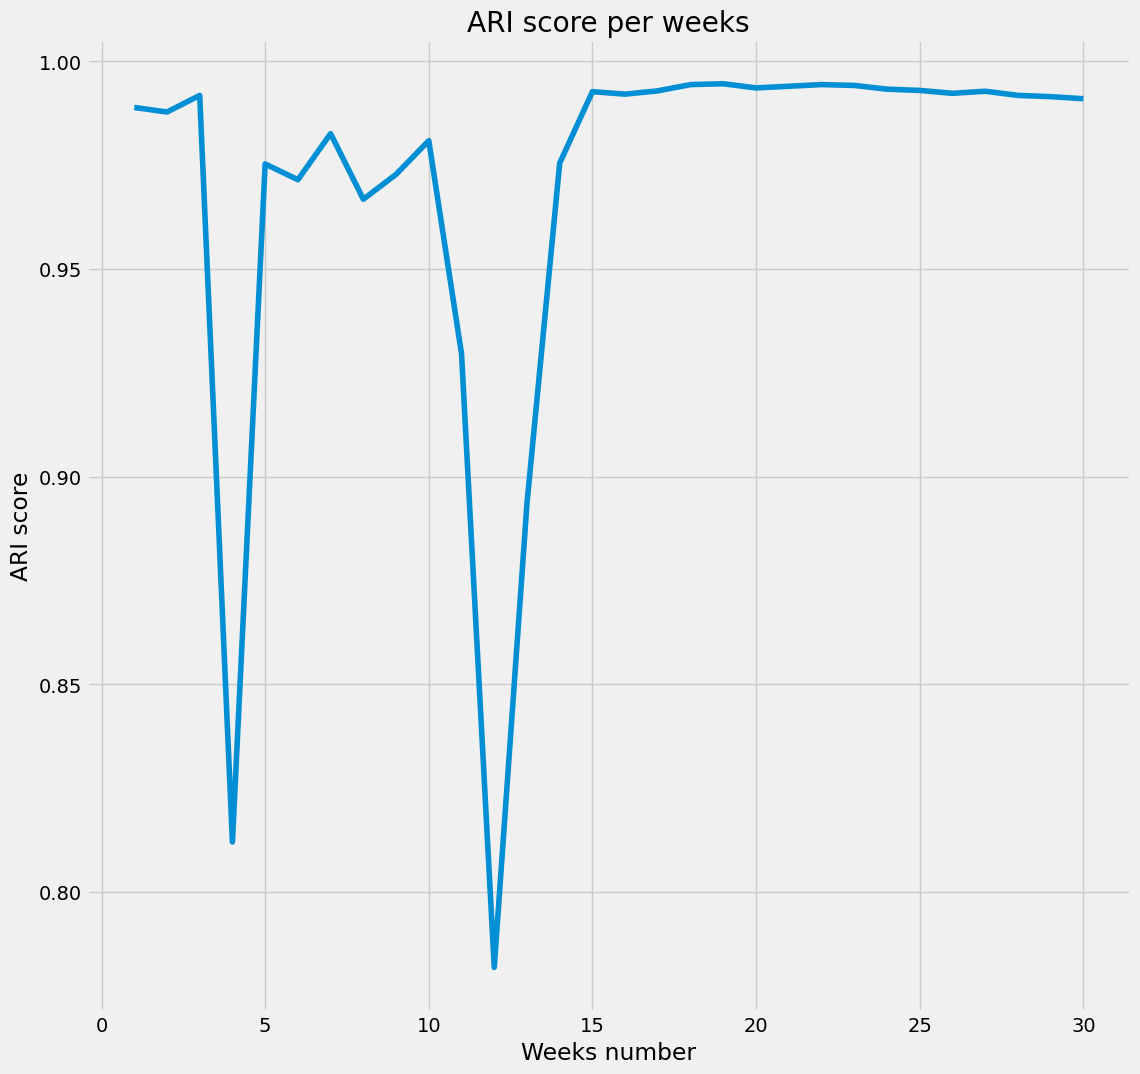


The simulation is now done.


In [16]:
print("Starting simulation script.\n")

all_clients, overall_earliest_purchase_date, overall_latest_purchase_date = load_data()
print("Data loaded.\n")

overall_week_numbers = (
    overall_latest_purchase_date - overall_earliest_purchase_date).days // 7
print(f"Earliest purchase date:{overall_earliest_purchase_date}, "
      f"latest purchase date:{overall_latest_purchase_date}, "
      f"overall_week_numbers:{overall_week_numbers}.\n")

weeks_number_for_first_period = get_week_number_when_first_period_includes_half_of_clients(
    all_clients, overall_earliest_purchase_date, overall_week_numbers)

print("\nStarting simulation.\n")
perform_simulation(
    overall_earliest_purchase_date,
    weeks_number_for_first_period,
    all_clients)

print("\nThe simulation is now done.")